<a href="https://colab.research.google.com/github/jstovold/ALIFE2023/blob/master/ExternalSignals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Cellular Automata Responding to External Signals
### James Stovold
### Nov 2022


<!-- > Indented block -->

Code to support ALIFE 2023 paper: 
 > J. Stovold, "Neural Cellular Automata can Respond to Signals"

Along with: [InternalSignals.ipynb](https://github.com/jstovold/ALIFE2023/blob/master/InternalSignals.ipynb)

Based on the Colab notebook developed by Mordvintsev et al. for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Code and materials are restricted for any and all use prior to publication; post-publication the code and associated materials are available under the Apache 2.0 license

<!-- Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

In [17]:
#@title Imports and Notebook Utilities

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import datetime

from scipy.ndimage.interpolation import rotate as scipy_rotate


import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def rotate(img, angle=90):
  img = scipy_rotate(img, angle=angle)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()


In [18]:
#@title Cellular Automata Parameters

# no "genome" for external signals:
PARAM_N  = 0                        # Number of genes in the genome
OTHER_N  = 12                       # Number of "empty" spaces in the genome for the CA to communicate between cells
ENV_N    = 1                        # Number of environment channels (not editable by cells)

# Total number of CA state channels (+ 4 for RGBA):
CHANNEL_N = 4 + PARAM_N + OTHER_N + ENV_N  

TARGET_PADDING = 15                 # Number of pixels used to pad the target image border
TARGET_SIZE = 30
TARGET_PADDED_SIZE = TARGET_SIZE + TARGET_PADDING * 2

BATCH_SIZE = 12
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

EXPERIMENT_TYPE = "Regenerating" #param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

BEHAVIOUR_SWITCH=2000               # at what point do we change the way we present the target images to the network?

fix_seed = True                     # for reproducibility


In [19]:
#@title CA Model and Utilities

from tensorflow.keras.layers import Conv2D


def load_image(url, max_size=TARGET_SIZE, zoom=1):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size*zoom, max_size*zoom), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  img[...,:3] *= img[..., 3:]
  return img


def load_heart(colour="green", zoom=1):
  url = "https://github.com/jstovold/ALIFE2023/blob/master/hearts/emoji_u2764_" + colour + ".png?raw=true"
  return load_image(url, zoom=zoom)


def load_gecko(colour='green',zoom=1):
  url = f"https://github.com/jstovold/ALIFE2023/blob/master/geckos/emoji_u1f98e_{colour}.png?raw=true"
  return load_image(url, zoom=zoom)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb


def get_channels(x, ch=[5,6,7]):
  rgb, a = x[..., ch], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x, threshold = 0.1):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > threshold

def get_living(x):
  alpha = x[0, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


def make_seed(size, n=1): 
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x



@tf.function
def get_stim(jitter=False):
  size = TARGET_PADDED_SIZE
  stim_x = (size // 2) - (TARGET_SIZE // 10)
  stim_y = (size // 2) - (TARGET_SIZE // 10)
  
  if jitter:    
    rand = tf.random.uniform(shape=(), minval=-1, maxval=1, dtype=tf.int32)
    stim_x = stim_x + rand
    stim_y = stim_y + rand

  return (stim_x, stim_y)

class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu, name='layer1'),
          Conv2D(self.channel_n - ENV_N, 1, activation=None,             # no update for ENV_N state
              kernel_initializer=tf.zeros_initializer, name='layer2'),  
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)
    y = self.perceive(x, angle)

    
    z = self.dmodel(y)
    dx = z*step_size
    
    
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x = x[...,:-ENV_N] + dx * tf.cast(update_mask, tf.float32)
    x = tf.pad(x, tf.constant([[0,0],[0,0],[0,0], [0,ENV_N]]), constant_values=0) # add the environment vars back into the state vector (set to 0)
    
    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (1, 3, 3, 128)            6656      
                                                                 
 layer2 (Conv2D)             (1, 3, 3, 16)             2064      
                                                                 
Total params: 8,720
Trainable params: 8,720
Non-trainable params: 0
_________________________________________________________________


# Training

In [20]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)


def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72]  += (-tiled_pool[:,  :72] + ones[None, :, None]) * fade[None, :,    None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :]  += (-tiled_pool[:72,  :] + ones[:, None, None]) * fade[:,    None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, y0, step_i): 
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis2 = np.hstack(to_rgb(y0).numpy())
  vis = np.vstack([vis0, vis1, vis2])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(zoom(vis,2))

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()





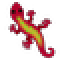

In [21]:
#@title Choose Target Image { vertical-output: true}

target_img = load_gecko('red')
imshow(zoom(to_rgba(target_img), 2), fmt='png')



(60, 60, 4)


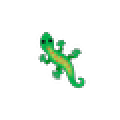

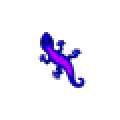

In [22]:
#@title Pull the images from github according to genome { vertical-output: true }

target_img_1 = load_gecko('green')
target_img_2 = load_gecko('blue')

h, w = target_img_1.shape[:2]

p = (TARGET_PADDED_SIZE - h) // 2
padded_img_1 = tf.pad(target_img_1, [[p, p], [p,p], [0,0]])
padded_img_2 = tf.pad(target_img_2, [[p, p], [p,p], [0,0]])

print(padded_img_1.shape)

imshow(zoom(to_rgba(padded_img_1),2),fmt='png')
imshow(zoom(to_rgba(padded_img_2),2),fmt='png')



In [23]:
#@title Initialize Training { vertical-output: true}


h, w = padded_img_1.shape[:2]
print(h,w)
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:]  = 1.0
seed[h//2, w//2, -ENV_N:] = 0.0

def loss_f(x, y):
  return tf.reduce_mean(tf.square(to_rgba(x)-to_rgba(y)), [-2, -3, -1])
  
ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [3000, 5000, 6000, 10000], [lr, lr*0.5, lr * 0.1, lr * 0.05, lr*0.01])
trainer = tf.keras.optimizers.Adam(lr_sched)


loss0 = loss_f(seed[None,...], padded_img_1[None,...]).numpy() 

pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0),
                  y=np.repeat(padded_img_1[None, ...], POOL_SIZE, 0),
                  z=np.repeat(0, POOL_SIZE,0))

!mkdir -p train_log && rm -f train_log/*

60 60


batch (before/after):


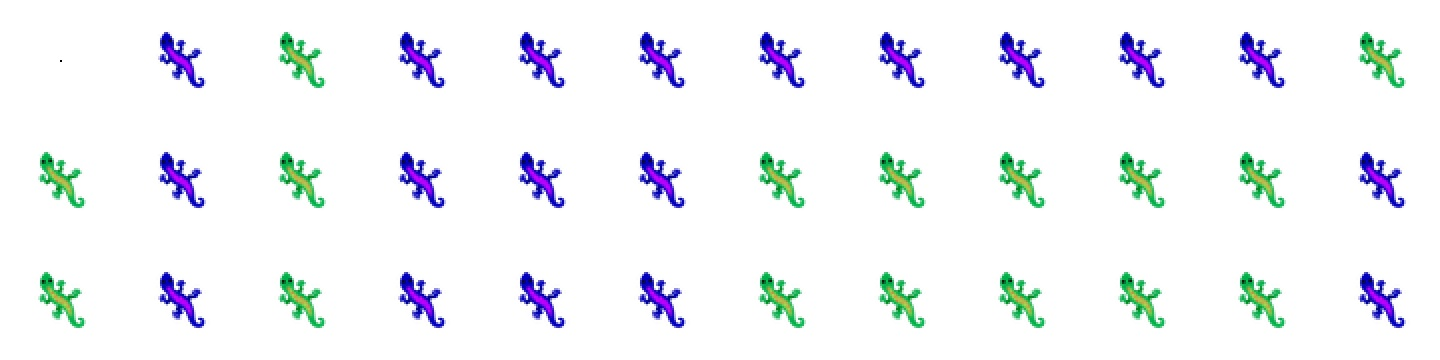

[ 0  1  2  5 13 11 24 14 10  4 16  3]


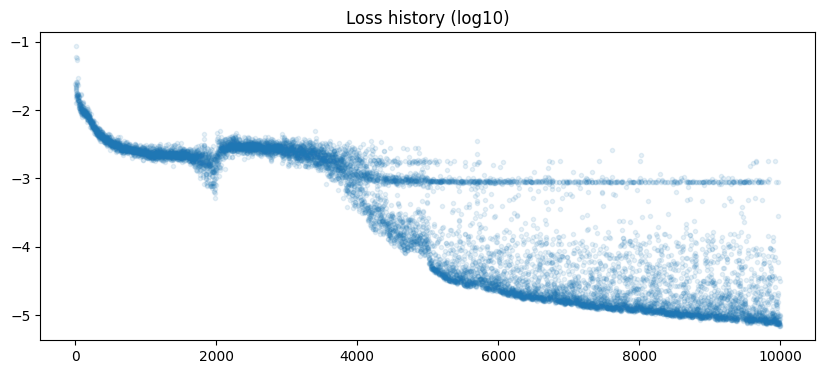

 step: 10001, log10(loss): -5.165
 0:18:42.966621


In [24]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x, y):
  iter_n = tf.random.uniform([], 64, 200, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x, y))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss


@tf.function
def make_seed_env(): 
  h, w = (TARGET_PADDED_SIZE, TARGET_PADDED_SIZE)
  seed = np.zeros([h, w, CHANNEL_N], np.float32)
  seed[h//2, w//2, 3:] = 1.0
  seed[h//2,w//2,-ENV_N:] = 0
  return seed


@tf.function
def get_target(numSignals): 
  if numSignals % 2 == 0:
    target_img_scale = target_img_1
  else:
    target_img_scale = target_img_2

  img_w = target_img_scale.shape[:1][0]
  p = (TARGET_PADDED_SIZE - img_w) // 2
  pad_target_temp = tf.pad(to_rgba(target_img_scale), [[p, p], [p,p], [0,0]])
  return(pad_target_temp)


if fix_seed:
  tf.random.set_seed(1)

tic = datetime.datetime.now()
switch = 0
switch_step = 3
mirror = False

start_i = 6
end_i = 9
num_seeded = 3

for i in range(10000+1):

  if i == BEHAVIOUR_SWITCH:
    # move signal to middling outputs rather than best outputs
    # (keep training best outputs to persist)
    start_i    = 6
    end_i      = 12
    num_seeded = 1

  
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    y0 = batch.y
    z0 = batch.z
    loss_rank = loss_f(x0, y0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    y0 = y0[loss_rank]
    z0 = z0[loss_rank]
    
    x0[:num_seeded] = make_seed_env()
    y0[:num_seeded] = get_target(0) 
    z0[:num_seeded] = np.zeros(num_seeded)
    if DAMAGE_N:
      # get location of signal input:
      stim_x, stim_y = get_stim(jitter=True)
      
      x0[start_i:end_i, stim_y, stim_x, -ENV_N:] = 1.0
      z0[start_i:end_i]     += 1   # keep track of how many signals this NCA has been given
      for z in range(start_i, end_i):
        y0[z,...] = get_target(z0[z])
      
  else:
    seed = make_seed_env()
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    
  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0
    batch.z[:] = z0
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
  
  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, y0, step_i)
    print(z0)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')
toc = datetime.datetime.now()
print("\n", toc - tic)
loading_from_file = False

# Figures

In [9]:
#@title Load model from file {vertical-output:true}
loading_from_file = False

if loading_from_file:
  from google.colab import drive
  drive.mount('/content/drive')

 
  !cp /content/drive/MyDrive/Research/NCAs/RSOS\ Paper/Models/gecko_colourchange_nostoch.zip /content/model.zip
  !rm -rf /content/model/
  !mkdir /content/model/
  !unzip -q -d /content/model/ /content/model.zip
  !rm /content/model.zip


In [25]:
#@title Training Progress (Checkpoints)  

model_nums = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
loading_from_file = False
if loading_from_file:
  root_dir = '/content/model/content/'
else:
  root_dir = ''

models = []
for i in model_nums:
  ca = CAModel()
  ca.load_weights(root_dir + 'train_log/%04d'%i)
  models.append(ca)


x = np.zeros([len(models), TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, CHANNEL_N], np.float32)
x[..., TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 3:] = 1.0
x[:, TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE//2, -ENV_N:] = 0.0

out_fn = 'gecko_colourchange1.mp4'

models2 = models.copy()
x2 = x.copy()
models3 = models.copy()
x3 = x.copy()
models4 = models.copy()
x4 = x.copy()

stim_xa,stim_ya = get_stim();
stim_xb,stim_yb = get_stim(jitter=True);
stim_xc,stim_yc = get_stim();


with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(1500):
    if i == 500 or i == 1000:

      stim_x, stim_y = get_stim()
      x2[:, stim_ya, stim_xa, -ENV_N:] = 1.0
      stim_x, stim_y = get_stim(jitter=True)
      x3[:, stim_yb, stim_xb, -ENV_N:] = 1.0
      stim_x, stim_y = get_stim()
      x4[:, stim_yc+1, stim_xc+1, -ENV_N:] = 1.0
      
      
    


    vis = np.hstack(to_rgb(x))
    vis2 = np.hstack(to_rgb(x2))
    vis3 = np.hstack(to_rgb(x3))
    vis4 = np.hstack(to_rgb(x4))
    vis5 = np.hstack(get_channels(x2, [5,6,7]))      #]
    vis6 = np.hstack(get_channels(x2, [8,9,10]))     #] visualise the hidden layers
    vis7 = np.hstack(get_channels(x2, [11,12,13]))   #]
    vis8 = np.hstack(get_channels(x2, [14,14,14]))   #]

    vis = np.vstack((
                      vis
                     ,vis2
                     ,vis3
                     ,vis4
                     ,vis5
                     ,vis6
                     ,vis7
                     ,vis8
    ))



    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models2, x2):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models3, x3):
      xk[:] = ca(xk[None,...])[0]
    for ca, xk in zip(models4, x4):
      xk[:] = ca(xk[None,...])[0]
      
mvp.ipython_display(out_fn)



100%|██████████| 1500/1500 [04:37<00:00,  5.40it/s]


In [26]:
#@title Produce output for article
# takes an example organism, provides the signal and records the output
# recorded stops at different points to provide static output for article

model_nums = [10000] 
loading_from_file = False

if loading_from_file:
  root_dir = '/content/model/content/'
else:
  root_dir = ''

models = []
for i in model_nums:
  ca = CAModel()
  ca.load_weights(root_dir + 'train_log/%04d'%i)
  models.append(ca)


x = np.zeros([len(models), TARGET_PADDED_SIZE, TARGET_PADDED_SIZE, CHANNEL_N], np.float32)
x[..., TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE // 2, 3:] = 1.0
x[:, TARGET_PADDED_SIZE//2, TARGET_PADDED_SIZE//2, -ENV_N:] = 0.0

out_fn = 'gecko_colourchange2.mp4'

models100 = models.copy()
x100 = x.copy()
models102 = models.copy()
x102 = x.copy()
models104 = models.copy()
x104 = x.copy()
models106 = models.copy()
x106 = x.copy()
models120 = models.copy()
x120 = x.copy()
models140 = models.copy()
x140 = x.copy()
models160 = models.copy()
x160 = x.copy()


y100 = x.copy()
y102 = x.copy()
y104 = x.copy()
y106 = x.copy()
y120 = x.copy()
y140 = x.copy()
y160 = x.copy()

stim_x, stim_y = get_stim(jitter=True);

with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(350):
    
    if i == 100: # or i == 500: # and i < 205:
      x100[:, stim_y, stim_x, -ENV_N:] = 1.0
      x102[:, stim_y, stim_x, -ENV_N:] = 1.0
      x104[:, stim_y, stim_x, -ENV_N:] = 1.0
      x106[:, stim_y, stim_x, -ENV_N:] = 1.0
      x120[:, stim_y, stim_x, -ENV_N:] = 1.0
      x140[:, stim_y, stim_x, -ENV_N:] = 1.0
      x160[:, stim_y, stim_x, -ENV_N:] = 1.0
      

    vis100 = np.hstack(to_rgb(x100))
    vis102 = np.hstack(to_rgb(x102))
    vis104 = np.hstack(to_rgb(x104))
    vis106 = np.hstack(to_rgb(x106))
    vis120 = np.hstack(to_rgb(x120))
    vis140 = np.hstack(to_rgb(x140))
    vis160 = np.hstack(to_rgb(x160))
    
    vis = np.hstack((
                      vis100
                     ,vis102
                     ,vis104
                     ,vis106
                     ,vis120
                     ,vis140
                     ,vis160
    ))

    
    if i == 100 or i == 200:  # when do we provide the stimulus?
      y100[:, stim_y, stim_x, -ENV_N:] = 1.0
      y102[:, stim_y, stim_x, -ENV_N:] = 1.0
      y104[:, stim_y, stim_x, -ENV_N:] = 1.0
      y106[:, stim_y, stim_x, -ENV_N:] = 1.0
      y120[:, stim_y, stim_x, -ENV_N:] = 1.0
      y140[:, stim_y, stim_x, -ENV_N:] = 1.0
      y160[:, stim_y, stim_x, -ENV_N:] = 1.0
      


    vis100y = np.hstack(to_rgb(y100))
    vis102y = np.hstack(to_rgb(y102))
    vis104y = np.hstack(to_rgb(y104))
    vis106y = np.hstack(to_rgb(y106))
    vis120y = np.hstack(to_rgb(y120))
    vis140y = np.hstack(to_rgb(y140))
    vis160y = np.hstack(to_rgb(y160))
    
    visy = np.hstack((
                      vis100y
                     ,vis102y
                     ,vis104y
                     ,vis106y
                     ,vis120y
                     ,vis140y
                     ,vis160y
    ))


    vid.add(zoom(np.vstack((vis, visy)), 2))


    if i <= 100:
      for ca, xk in zip(models100, x100):
        xk[:] = ca(xk[None,...])[0]
    if i <= 102:
      for ca, xk in zip(models102, x102):
        xk[:] = ca(xk[None,...])[0]
    if i <= 104:
      for ca, xk in zip(models104, x104):
        xk[:] = ca(xk[None,...])[0]
    if i <= 106:
      for ca, xk in zip(models106, x106):
        xk[:] = ca(xk[None,...])[0]
    if i <= 120:
      for ca, xk in zip(models120, x120):
        xk[:] = ca(xk[None,...])[0]
    if i <= 140:
      for ca, xk in zip(models140, x140):
        xk[:] = ca(xk[None,...])[0]
    if i <= 200:
      for ca, xk in zip(models160, x160):
        xk[:] = ca(xk[None,...])[0]



    if i <= 200:
      for ca, xk in zip(models100, y100):
        xk[:] = ca(xk[None,...])[0]
    if i <= 202:
      for ca, xk in zip(models102, y102):
        xk[:] = ca(xk[None,...])[0]
    if i <= 204:
      for ca, xk in zip(models104, y104):
        xk[:] = ca(xk[None,...])[0]
    if i <= 206:
      for ca, xk in zip(models106, y106):
        xk[:] = ca(xk[None,...])[0]
    if i <= 220:
      for ca, xk in zip(models120, y120):
        xk[:] = ca(xk[None,...])[0]
    if i <= 240:
      for ca, xk in zip(models140, y140):
        xk[:] = ca(xk[None,...])[0]
    if i <= 300:
      for ca, xk in zip(models160, y160):
        xk[:] = ca(xk[None,...])[0]



mvp.ipython_display(out_fn)



100%|██████████| 350/350 [00:14<00:00, 24.00it/s]
